In [ ]:
from dotenv import load_dotenv

# .env 파일에 등록된 변수(데이터)를 os 환경변수에 적용
load_dotenv()

True

# Graph v1

## State
- add_messages
> 기존 메시지가 있으면, update / 없으면, add 

In [4]:
from typing import Annotated

from typing_extensions import TypedDict
from langgraph.graph.message import add_messages

In [5]:
class State(TypedDict):
    messages: Annotated[list, add_messages]

## Node

In [6]:
from langchain_openai import ChatOpenAI

llm = ChatOpenAI(model="gpt-4o-mini")

In [7]:
def chatbot(state:State) -> State:
    return {
        "messages": [
            llm.invoke(
                state["messages"]
            )
        ]
    }

## Create Graph 

In [8]:
from langgraph.graph import StateGraph

# graph 객체 생성(선언)
# simple_graph 상 데이터 전달에 사용할 객체 -> State 클래스 
simple_graph = StateGraph(State)

## add Node

In [ ]:
# openai_chatbot -> 나중에 엣지가 노드들을 식별하는데 사용하는 이름 
simple_graph.add_node(
    "openai_chatbot", chatbot
)

## Start Node

In [10]:
# 그래프에 정의된(add_node) Node들 중에서 
# 시작으로 사용할 Node 선언(정의) 
simple_graph.set_entry_point(
    "openai_chatbot" 
)

## End Node

In [11]:
# 그래프에 정의된(add_node) Node들 중에서 
# 끝으로 사용할 Node 선언(정의) 
simple_graph.set_finish_point(
    "openai_chatbot"
)

## Compile Graph 

In [ ]:
# compile()를 통해서 객체화(메모리에 올리감)
# simple_graph에 포함된 Node들이 모두 메모리에 올라감
compiled_graph = simple_graph.compile()

## Display Graph

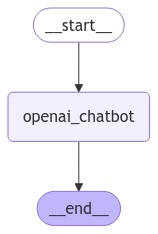

In [13]:
from IPython.display import Image, display

try:
    display(
        Image(
            compiled_graph.get_graph().draw_mermaid_png()
        )
    )
except:
    pass 

## Run Graph
- CallbackHandler
  - Langsmin를 통해 Graph 로깅을 도와주는 객체

In [14]:
from langfuse.callback import CallbackHandler

handler = CallbackHandler()

Langfuse client is disabled since no public_key was provided as a parameter or environment variable 'LANGFUSE_PUBLIC_KEY'. See our docs: https://langfuse.com/docs/sdk/python/low-level-sdk#initialize-client


In [15]:
from langchain_core.messages import HumanMessage

for chunk in compiled_graph.stream(
    # Start Node에게 전달할 Input data
    {
      "messages":[
          HumanMessage(content="대한민국의 수도는?")
      ]
    }, 
    # 로깅 처리할 설정 
    config={
        "callbacks":[
            handler
        ]
    }
):
    print(chunk)

{'openai_chatbot': {'messages': [AIMessage(content='대한민국의 수도는 서울입니다.', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 8, 'prompt_tokens': 13, 'total_tokens': 21, 'completion_tokens_details': {'audio_tokens': None, 'reasoning_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': None, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_9b78b61c52', 'finish_reason': 'stop', 'logprobs': None}, id='run-7f6281ec-2849-4dfb-9a21-e4cf50b84a0e-0', usage_metadata={'input_tokens': 13, 'output_tokens': 8, 'total_tokens': 21, 'input_token_details': {'cache_read': 0}, 'output_token_details': {'reasoning': 0}})]}}


# Graph v2

## State

In [24]:
from typing import Annotated

from typing_extensions import TypedDict
from langgraph.graph.message import add_messages

In [25]:
class State(TypedDict):
    """
    {
      "input":"Hello",
      "result":5
    }
    """
    input: str    # 사용자 input data
    result: int   # Node의 result data

## Node

In [26]:
def len_str(state:State) -> State:
    # hello 
    input = state["input"]
    # 5
    result = len(input)
    return {
        "result": result
    }

In [27]:
def add_one(state:State) -> State:
    # 5
    input = state["result"]
    # 6
    result = input + 1
    return {
        "result": result
    }

In [28]:
def multi_one(state:State) -> State:
    # 5
    input = state["result"]
    # 6
    result = input * 2
    return {
        "result": result
    }

In [29]:
def sub_one(state:State) -> State:
    # 5
    input = state["result"]
    # 6
    result = input - 1
    return {
        "result": result
    }

## Create Graph

In [30]:
from langgraph.graph import StateGraph

# graph 객체 생성(선언)
# simple_graph 상 데이터 전달에 사용할 객체 -> State 클래스 
simple_graph = StateGraph(State)

## add Node

In [31]:
simple_graph.add_node(
    "len_str", len_str
)

simple_graph.add_node(
    "add_one", add_one
)
# -----------------------
simple_graph.add_node(
    "multi_one", multi_one
)

simple_graph.add_node(
    "sub_one", sub_one
)

## add Edge

In [32]:
from langgraph.graph import START, END 

### Start Node
> start -> len_str 

In [33]:
simple_graph.add_edge(
    START, "len_str"
)

### Convined Nodes
> len_str -> add_one

In [34]:
simple_graph.add_edge(
    "len_str", "add_one"
)

In [35]:
simple_graph.add_edge(
    "add_one", "multi_one"
    )

In [36]:
simple_graph.add_edge(
    "multi_one", "sub_one"
)

### End Node
> add_one -> end

In [37]:
simple_graph.add_edge(
    "sub_one", END
)

## Compile Graph

In [38]:
compiled_graph = simple_graph.compile()

## Display Graph

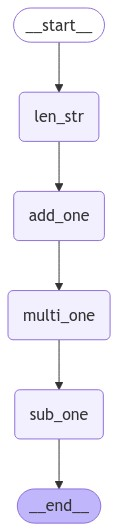

In [39]:
from IPython.display import Image, display

try:
    display(
        Image(
            compiled_graph.get_graph().draw_mermaid_png()
        )
    )
except:
    pass 

## Run Graph

In [40]:
for chunk in compiled_graph.stream(
    # Start Node에게 전달할 Input data
    {
      "input":"Hello World"
    }
):
    print(chunk)

{'len_str': {'result': 11}}
{'add_one': {'result': 12}}
{'multi_one': {'result': 24}}
{'sub_one': {'result': 23}}


# Graph V3

## State

In [26]:
from typing_extensions import TypedDict, Optional

In [27]:
class State(TypedDict):
    input: Optional[str] = None
    node_output: Optional[int] = None
    is_stop: Optional[bool] = False



## Node

In [28]:
def len_str(state:State) -> State:
    # hello 
    input = state["input"]
    
    result = len(input)
    return {
        **state, # state에 저장된 데이터를 다음 Node 전달
        "node_output": result
    }

In [29]:
def add_one(state:State) -> State:
    # 5
    input = state["node_output"]
    is_stop = state["is_stop"]

    result = input + 1
    if result> 10:
        is_stop = True

    return {
        **state, # state에 저장된 데이터를 다음 Node 전달
        "node_output": result,
        "is_stop": is_stop
    }

In [30]:
def add_two(state:State) -> State:
    # 5
    input = state["node_output"]
    result = input + 2
    return {
        **state, # state에 저장된 데이터를 다음 Node 전달
        "node_output": result
    }

## Create Graph

In [31]:
from langgraph.graph import StateGraph

# graph 객체 생성(선언)
# simple_graph 상 데이터 전달에 사용할 객체 -> State 클래스 
simple_graph = StateGraph(State)

## Add Nodes

In [32]:

simple_graph.add_node(
    "len_str", len_str
)

simple_graph.add_node(
    "add_one", add_one
)
# -----------------------
simple_graph.add_node(
    "add_two", add_two
)

## Add Edge

In [33]:
from langgraph.graph import START, END 

simple_graph.add_edge(
    START , "len_str"
)

simple_graph.add_edge(
    "len_str" , "add_one"
)

## Add conditional edge

In [34]:
def is_stop(state: State) -> str:
    is_stop = state["is_stop"]
    if is_stop:
        return "go_stop" 
    
    else:
        return 'go_to_add_two_fnc' 


In [35]:
simple_graph.add_conditional_edges(
    "add_one",
    is_stop,
    {
        "go_to_add_two_fnc": "add_two",
        "go_stop": END
    }
)

In [36]:
simple_graph.add_edge(
    "add_two", "add_one"
)

## Compile Graph

In [37]:
compiled_graph = simple_graph.compile()

## Display Graph

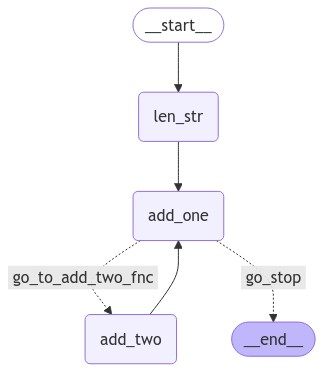

In [38]:
from IPython.display import Image, display

try:
    display(
        Image(
            compiled_graph.get_graph().draw_mermaid_png()
        )
    )
except:
    pass 

## Run Graph

In [39]:
for chunk in compiled_graph.stream(
        {
            "input":"Hello", "is_stop":False
             
        }   
            ):
    print(chunk) 

{'len_str': {'input': 'Hello', 'node_output': 5, 'is_stop': False}}
{'add_one': {'input': 'Hello', 'node_output': 6, 'is_stop': False}}
{'add_two': {'input': 'Hello', 'node_output': 8, 'is_stop': False}}
{'add_one': {'input': 'Hello', 'node_output': 9, 'is_stop': False}}
{'add_two': {'input': 'Hello', 'node_output': 11, 'is_stop': False}}
{'add_one': {'input': 'Hello', 'node_output': 12, 'is_stop': True}}
